#Simple Weather Data Analysis

# 1.Data preprocessing

In [ ]:
from google.colab import files
files = files.upload()

Saving AirQualityUCI.xlsx to AirQualityUCI.xlsx


In [ ]:
import numpy as np
import pandas as pd
raw_data = pd.read_excel("AirQualityUCI.xlsx")
data = raw_data.copy()

In [ ]:
# Missing values appear in the original data as -200, they are replace with np.nan

condition = data != -200
data.where(condition, np.nan, inplace=True)
data

,Date,Time,CO(GT),PT08.S1(CO),NMHC(GT),C6H6(GT),PT08.S2(NMHC),NOx(GT),PT08.S3(NOx),NO2(GT),PT08.S4(NO2),PT08.S5(O3),T,RH,AH
0,2004-03-10,18:00:00,2.60,1360.00,150.00,11.88,1045.50,166.00,1056.25,113.00,1692.00,1267.50,13.60,48.88,0.76
1,2004-03-10,19:00:00,2.00,1292.25,112.00,9.40,954.75,103.00,1173.75,92.00,1558.75,972.25,13.30,47.70,0.73
2,2004-03-10,20:00:00,2.20,1402.00,88.00,9.00,939.25,131.00,1140.00,114.00,1554.50,1074.00,11.90,53.98,0.75
3,2004-03-10,21:00:00,2.20,1375.50,80.00,9.23,948.25,172.00,1092.00,122.00,1583.75,1203.25,11.00,60.00,0.79
4,2004-03-10,22:00:00,1.60,1272.25,51.00,6.52,835.50,131.00,1205.00,116.00,1490.00,1110.00,11.15,59.58,0.79
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9352,2005-04-04,10:00:00,3.10,1314.25,nan,13.53,1101.25,471.70,538.50,189.80,1374.25,1728.50,21.85,29.25,0.76
9353,2005-04-04,11:00:00,2.40,1162.50,nan,11.36,1027.00,353.30,603.75,179.20,1263.50,1269.00,24.33,23.72,0.71
9354,2005-04-04,12:00:00,2.40,1142.00,nan,12.37,1062.50,293.00,603.25,174.70,1240.75,1092.00,26.90,18.35,0.64
9355,2005-04-04,13:00:00,2.10,1002.50,nan,9.55,960.50,234.50,701.50,155.70,1041.00,769.75,28.32,13.55,0.51


In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9357 entries, 0 to 9356
Data columns (total 15 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   Date           9357 non-null   datetime64[ns]
 1   Time           9357 non-null   object        
 2   CO(GT)         7674 non-null   float64       
 3   PT08.S1(CO)    8991 non-null   float64       
 4   NMHC(GT)       914 non-null    float64       
 5   C6H6(GT)       8991 non-null   float64       
 6   PT08.S2(NMHC)  8991 non-null   float64       
 7   NOx(GT)        7718 non-null   float64       
 8   PT08.S3(NOx)   8991 non-null   float64       
 9   NO2(GT)        7715 non-null   float64       
 10  PT08.S4(NO2)   8991 non-null   float64       
 11  PT08.S5(O3)    8991 non-null   float64       
 12  T              8991 non-null   float64       
 13  RH             8991 non-null   float64       
 14  AH             8991 non-null   float64       
dtypes: datetime64[ns](1),

In [ ]:
data.describe()

,CO(GT),PT08.S1(CO),NMHC(GT),C6H6(GT),PT08.S2(NMHC),NOx(GT),PT08.S3(NOx),NO2(GT),PT08.S4(NO2),PT08.S5(O3),T,RH,AH
count,7674.00,8991.00,914.00,8991.00,8991.00,7718.00,8991.00,7715.00,8991.00,8991.00,8991.00,8991.00,8991.00
mean,2.15,1099.71,218.81,10.08,939.03,246.88,835.37,113.08,1456.14,1022.78,18.32,49.23,1.03
std,1.45,217.08,204.46,7.45,266.83,212.97,256.82,48.36,346.20,398.48,8.83,17.32,0.40
min,0.10,647.25,7.00,0.15,383.25,2.00,322.00,2.00,551.00,221.00,-1.90,9.18,0.18
25%,1.10,936.75,67.00,4.44,734.38,98.00,657.88,78.00,1226.62,731.38,11.79,35.81,0.74
50%,1.80,1063.00,150.00,8.24,909.00,179.80,805.50,109.00,1462.75,963.25,17.75,49.55,1.00
75%,2.90,1231.25,297.00,13.99,1116.25,326.00,969.25,142.00,1673.50,1273.38,24.40,62.50,1.31
max,11.90,2039.75,1189.00,63.74,2214.00,1479.00,2682.75,339.70,2775.00,2522.75,44.60,88.73,2.23


# 2.Air humidity chart

###2.1 Calculating daily average air humidity

In [ ]:
# Grouping data by date and aggregating values by their mean + dropping redundant columns
daily = data.groupby(["Date"]).mean().drop(daily.columns[0:9], axis=1)

### 2.2 Daily humidity chart

[(0.0, 100.0),
 Text(0, 0.5, 'Relative Humidity'),
 Text(0.5, 0, 'Date'),
 Text(0.5, 1.0, 'Daily Humidity')]

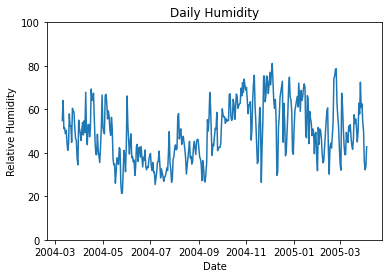

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Chart
rh_fig = sns.lineplot(x=daily.index, y=daily["RH"])

# Setting title and lables + scaling axis
rh_fig.set(xlabel='Date', ylabel='Relative Humidity', title='Daily Humidity', ylim=(0,100))

# 3.Filling missing values with relative humidity median

In [ ]:
daily["RH"].fillna(daily["RH"].median(), inplace=True)

# 4.Outliers

### 4.1 Detrending data

Detrending in this case is necessary, as there is obvious seasonality in the data. It will prevent algorythm to pick outliers only among datapoints most distant from global average.


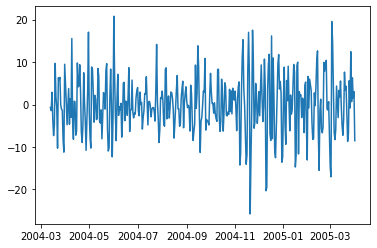

In [ ]:
import statsmodels.api as sm

result = sm.tsa.seasonal_decompose(daily["RH"])
detrend = daily["RH"] - result.trend

plt.plot(detrend)

### 4.2 Use of DBSCAN algorythm to identify outliers

In [ ]:
from sklearn.cluster import DBSCAN
pred = DBSCAN(eps=0.4, min_samples=5).fit_predict(np.array(detrend.fillna(0)).reshape(-1, 1))

# Saving outliers as pd.Series
outliers = pd.Series(pred, index=daily.index)

### 4.3 Mapping outliers in the dataset

In [ ]:
daily["outlier"] = outliers < 0

Number of outlier found by the algorythm

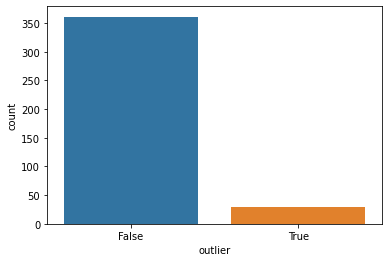

In [ ]:
sns.countplot(x=daily["outlier"])

### 4.4 Relative humidity chart with mapped outliers

In [ ]:
daily["out_plot"] = daily.loc[daily["outlier"]==True, "RH"]

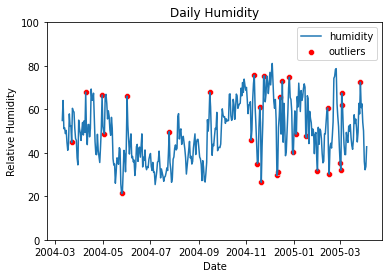

In [ ]:
# Line plot for relative humidity
rh_out = sns.lineplot(x=daily.index, y=daily["RH"]) 

# Adding outliers as red dots
sns.scatterplot(x=daily.index, y=daily["out_plot"], color="red")

# Title and lables
rh_out.set(xlabel='Date', ylabel='Relative Humidity', title='Daily Humidity', ylim=(0,100))

# Legend
plt.legend(labels=['humidity', 'outliers'])

# 5.Temperature histogram

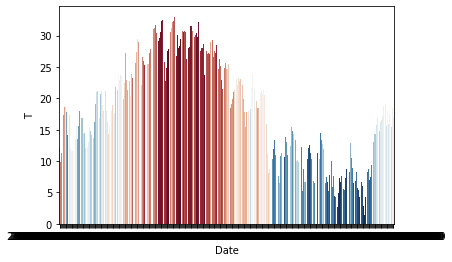

In [ ]:
# Setting plot color palette
pal = sns.color_palette("RdBu_r", len(daily.index))

# Making higher values redshifted and lower blueshifted
rank = daily["T"].argsort().argsort()
sns.barplot(x=daily.index, y=daily["T"], palette=np.array(pal)[rank])

# 6.Relative humidity and Temperature correlation

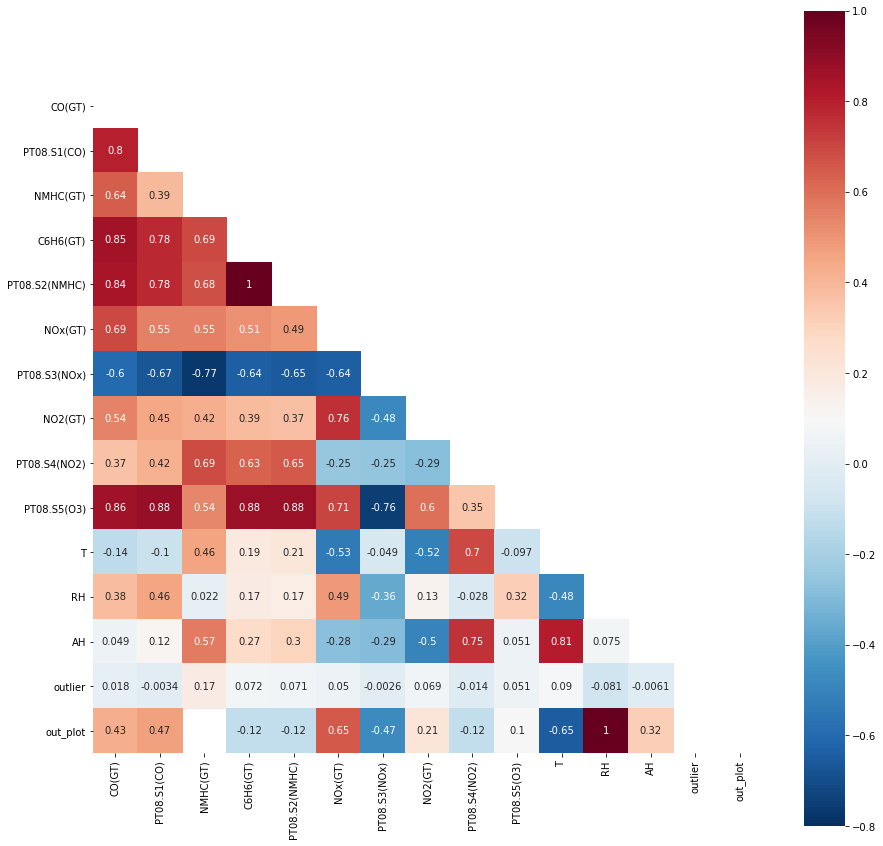

In [ ]:
# Creating correlation matrix.
corr_matrix = daily.corr(method='spearman')

# Removing mirrored data along diagonal
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))

# Limiting float dispaly format to 2 digits
pd.set_option('display.float_format', lambda x:f'{x:.2f}')

fig, ax = plt.subplots(figsize=(15,15))
sns.heatmap(corr_matrix, annot=True, square=True, ax=ax, vmin=-0.8, vmax=1, cmap="RdBu_r", mask=mask)

#7.Conclusions

1. In investigated period, relative humidity shows seasonality, with highest values being reached in July and lowest in December.
2. The same is true for Temperature distribution but with lowest values reached in February.
3. Relative humidity and temperature are quite strongly, negatively correlated (-0.48). The higher the tempreature, the lower the humidity.
